In [46]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import importlib
import sys
import os
import gower
from kneed import KneeLocator
import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchsummary
from torch.utils.data import Dataset, DataLoader

In [47]:
# import custom scripts
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))
import utils
importlib.reload(utils)
import models
importlib.reload(models)
import preprocessing
importlib.reload(preprocessing)

sns.set_palette('Set2')

In [48]:
df = preprocessing.load_dataset()
data_tensor = torch.tensor(df.to_numpy(), dtype=torch.float32)
binary_indices = utils.binary_indices
continuous_indices = utils.continuous_indices

In [49]:
class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        # Assuming dataframe is already scaled and prepared for neural network input
        self.data = torch.tensor(dataframe.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Returns a sample from the dataset
        return self.data[idx]
def create_dataloader(df, batch_size=1, shuffle=True):
    dataset = DataFrameDataset(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader
dataloader = create_dataloader(df, batch_size=32, shuffle=True)

# here insert the right model

In [50]:
torch.manual_seed(99)
model = models.Autoencoder_Encoder(binary_indices = binary_indices)
torchsummary.summary(model);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       352
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       136
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       27
├─Sequential: 1-2                        --
|    └─Linear: 2-6                       32
|    └─ReLU: 2-7                         --
|    └─Linear: 2-8                       144
|    └─ReLU: 2-9                         --
|    └─Linear: 2-10                      357
Total params: 1,048
Trainable params: 1,048
Non-trainable params: 0


In [51]:
epochs = 50
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
criterion = models.Autoencoder_Loss_Prob(binary_indices=binary_indices, 
                                         continuous_indices= continuous_indices)
for epoch in range(epochs):
    for data in dataloader:
        model.train()
        optimizer.zero_grad()
        x_reconstructed = model(data) 
        loss = criterion(data, x_reconstructed)
        #print(f"x rec = {x_reconstructed}\n, data = {data}")
        #loss = utils.gower_loss(data, x_reconstructed , binary_indices, continuous_indices)
        #print(loss)
        #sys.exit()
        loss.backward()
        optimizer.step()
        # Step the scheduler
    scheduler.step()
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]}')

print("Training complete")


Epoch [1/50], Loss: 0.1344, LR: 0.01
Epoch [11/50], Loss: 0.0222, LR: 0.005
Epoch [21/50], Loss: 0.0115, LR: 0.0025
Epoch [31/50], Loss: 0.0046, LR: 0.00125
Epoch [41/50], Loss: 0.0080, LR: 0.000625
Training complete


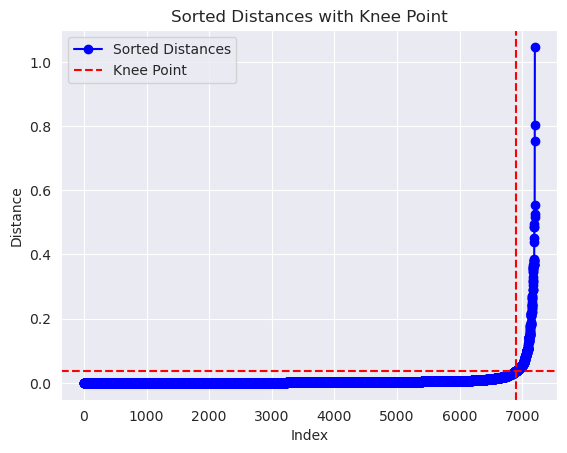

outliers: 304


In [53]:
model.eval()
distances = [criterion(data_tensor[i,:].unsqueeze(0), 
                        model(data_tensor)[i,:].unsqueeze(0)).item() 
             for i in range(len(df))]
sorted_distances = np.sort(distances)

# Use KneeLocator to find the knee point
knee = KneeLocator(range(len(sorted_distances)), 
                   sorted_distances, 
                   curve='convex', 
                   direction='increasing',
                   S = np.e)

# Plot the sorted distances and the kneepoint
plt.plot(sorted_distances, marker='o', linestyle='-', color='b', label='Sorted Distances')
plt.axvline(x=knee.knee, color='r', linestyle='--', label='Knee Point')
plt.axhline(y=sorted_distances[knee.knee], color='r', linestyle='--')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Distance')
plt.title('Sorted Distances with Knee Point')
plt.legend()
# Show the plot
plt.show()
print(f"outliers: {np.sum([1 if i > knee.knee_y else 0 for i in distances])}")

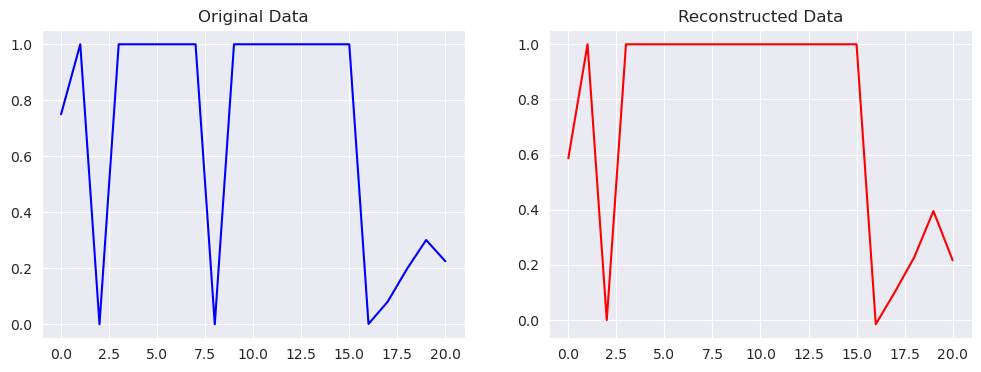

In [74]:
model.eval()
test_output = model(data_tensor)
# index = 1
index = 1626
index = 1077 ## onlly 0 in column 14
index = 6256
index = 4932
index = 0
original_data = data_tensor.numpy()[index]
reconstructed_data = test_output.detach().numpy()[index]
reconstructed_data_raw =  reconstructed_data.copy()
reconstructed_data[binary_indices] = (reconstructed_data[binary_indices] > 0.5)
#reconstructed_data[binary_indices] = (reconstructed_data[binary_indices])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(original_data, 'b')
axes[0].set_title('Original Data')
axes[1].plot(reconstructed_data, 'r')
axes[1].set_title('Reconstructed Data')
plt.show()

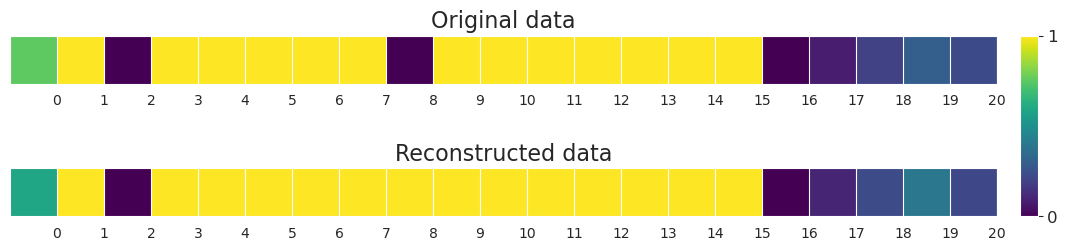

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 3), 
                         gridspec_kw={'height_ratios': [1, 1]})

# Reshape the 1D arrays to 2D (1 x number of elements)
original_data_2d = original_data.reshape(1, -1)
reconstructed_data_2d = reconstructed_data.reshape(1, -1)

# Generate tick positions and labels
x_positions = np.arange(original_data_2d.shape[1]) + 0.5
x_labels = np.arange(original_data_2d.shape[1])

# Heatmap for original data
cax1 = axes[0].imshow(original_data_2d, cmap='viridis', aspect='auto', vmin=0, vmax=1)
axes[0].set_title('Original data', fontsize=16)
axes[0].set_yticks([])  # Remove y-axis labels
axes[0].set_xticks(x_positions)
axes[0].set_xticklabels(x_labels)

# Heatmap for reconstructed data
cax2 = axes[1].imshow(reconstructed_data_2d, cmap='viridis', aspect='auto', vmin=0, vmax=1)
axes[1].set_title('Reconstructed data', fontsize=16)
axes[1].set_yticks([])  # Remove y-axis labels
axes[1].set_xticks(x_positions)
axes[1].set_xticklabels(x_labels)


# Adjust the layout to reduce the vertical space between subplots
plt.tight_layout(pad=2.5)  # Increase pad value to prevent overlap


# Add a shared colorbar for both heatmaps
cbar = fig.colorbar(cax1, ax=axes, 
                    orientation='vertical', 
                    fraction=0.1, 
                    pad=0.02,
                    aspect=10, 
                    shrink=1)  # Increase the fraction to make the colorbar larger
cbar.ax.tick_params(labelsize=12)  # Increase font size of colorbar labels
cbar.set_ticks([0, 1])  # Set colorbar to only show ticks at 0 and 1
cbar.set_ticklabels(['0', '1'])  # Explicitly set the tick labels to '0' and '1'


# Display the plot
plt.show()


In [59]:
print(f"max distance at index: {np.argmax(distances)}, min distance at index: {np.argmin(distances)}")

max distance at index: 1077, min distance at index: 1855


In [60]:
treshold = knee.knee_y
print(f"treshold was set to: {treshold}")

treshold was set to: 0.1015128493309021


In [61]:
(torch.tensor(df.iloc[1077,:]).unsqueeze(0))

/tmp/ipykernel_50333/915635261.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (torch.tensor(df.iloc[1077,:]).unsqueeze(0))


tensor([[2.0833e-01, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 4.7200e-04, 6.9638e-02,
         8.6957e-02, 4.1667e-01, 7.6562e-02]], dtype=torch.float64)

In [62]:
outlier_index = [-1 if i > treshold/2 else 0 for i in distances]
print(f"percentage of outliers was set to: {-np.sum(outlier_index)/len(outlier_index) * 100: .2f}%")

percentage of outliers was set to:  4.97%


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7200 samples in 0.029s...
[t-SNE] Computed neighbors for 7200 samples in 0.584s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7200
[t-SNE] Computed conditional probabilities for sample 2000 / 7200
[t-SNE] Computed conditional probabilities for sample 3000 / 7200
[t-SNE] Computed conditional probabilities for sample 4000 / 7200
[t-SNE] Computed conditional probabilities for sample 5000 / 7200
[t-SNE] Computed conditional probabilities for sample 6000 / 7200
[t-SNE] Computed conditional probabilities for sample 7000 / 7200
[t-SNE] Computed conditional probabilities for sample 7200 / 7200
[t-SNE] Mean sigma: 0.003135
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.399696
[t-SNE] KL divergence after 1000 iterations: 0.983499


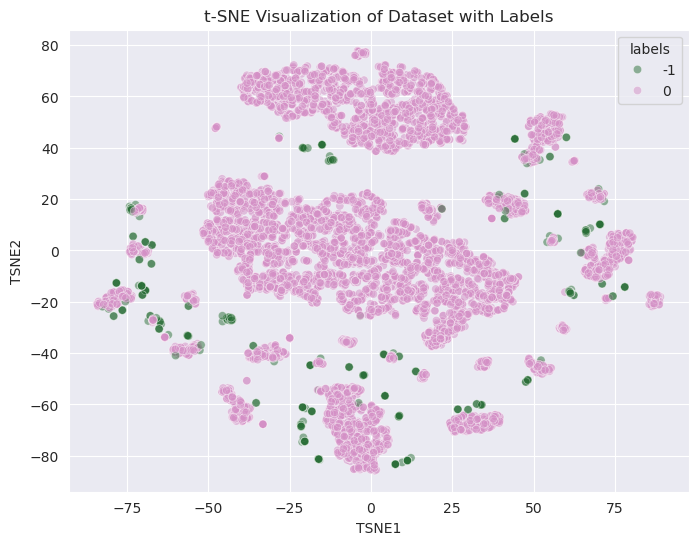

In [63]:
utils.plot_TSNE(df, outlier_index, dist_matrix=gower.gower_matrix(df))

In [188]:
pd.concat([
    np.abs(np.sum((df[np.array(outlier_index) == -1]).iloc[:,binary_indices]-1,axis = 1)).describe(),
    np.abs(np.sum((df[np.array(outlier_index) != -1]).iloc[:,binary_indices]-1,axis = 1)).describe()], 
    axis = 1,
    keys = ['falses/obs Outliers', 'Falses/obs non-out'])

falses/obs Outliers  Falses/obs non-out
count           234.000000         6966.000000
mean              2.192308            0.725093
std               0.839850            0.712976
min               0.000000            0.000000
25%               2.000000            0.000000
50%               2.000000            1.000000
75%               3.000000            1.000000
max               5.000000            5.000000

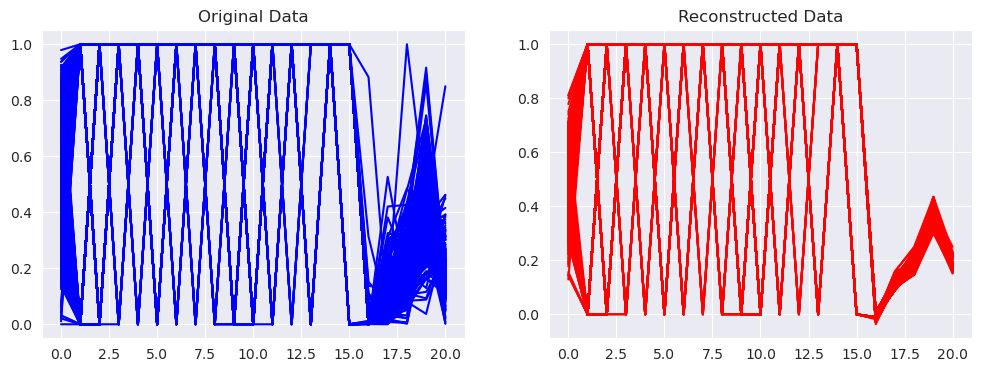

In [189]:
import random
model.eval()
test_output = model(data_tensor)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for i in random.sample(range(0, len(df)), 1000):
    original_data = data_tensor.numpy()[i]
    reconstructed_data = test_output.detach().numpy()[i]
    reconstructed_data[binary_indices] = (reconstructed_data[binary_indices] > 0.5)
    #reconstructed_data[binary_indices] = (reconstructed_data[binary_indices])
    axes[0].plot(original_data, 'b')
    axes[0].set_title('Original Data')
    axes[1].plot(reconstructed_data, 'r')
    axes[1].set_title('Reconstructed Data')
plt.show()

# how we chose losses


In [3]:
binary_temp_ind = [0]
continuous_temp_ind = [1]

x = torch.tensor([1.0, 1.0]).unsqueeze(0)
y = torch.tensor([0.5, 0.5]).unsqueeze(0)

bce = nn.BCELoss()
l1 = nn.MSELoss()

binary_loss = bce(x[:, binary_temp_ind], y[:, binary_temp_ind])
continuous_loss = l1(x[:, continuous_temp_ind], y[:, continuous_temp_ind])

combined_loss = (binary_loss + continuous_loss) / 2

print(f"binary_loss: {binary_loss.item()}, "
      f"continuous_loss: {continuous_loss.item()}, combined_loss: {combined_loss.item()}")



binary_loss: 50.0, continuous_loss: 0.25, combined_loss: 25.125


In [4]:
losses = []
for i in np.linspace(0.000001, 0.9999, 100):
    
    b = bce(i * torch.tensor([1.0]).unsqueeze(0),
            torch.tensor([0.]).unsqueeze(0))
    c = l1(i * torch.tensor([1.]).unsqueeze(0),
            torch.tensor([0.]).unsqueeze(0)) *2
    losses.append((b, c))


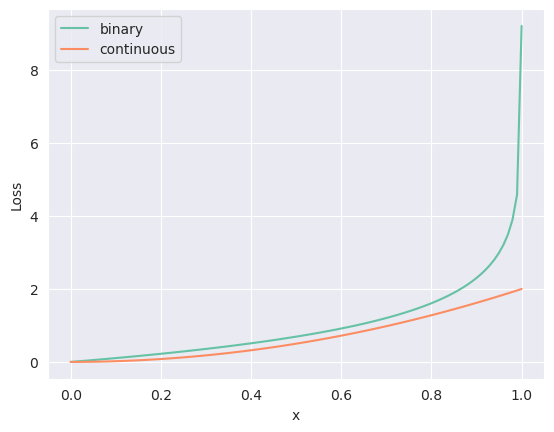

In [5]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0,1,100), [i[0].item() for i in losses], label='binary')
plt.plot(np.linspace(0,1,100), [i[1].item() for i in losses], label='continuous')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('x')
plt.show()


In [194]:
my3d_coord = model(data_tensor)

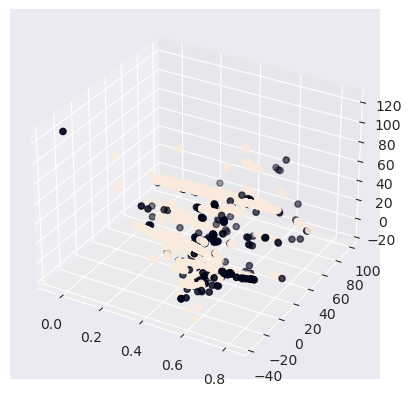

In [195]:
# plot 3 d
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(my3d_coord[:,0].detach().numpy(), my3d_coord[:,1].detach().numpy(), my3d_coord[:,2].detach().numpy(), c=outlier_index)

In [196]:
import plotly.graph_objects as go
import numpy as np

# Example data
points = my3d_coord.detach().numpy()
labels = outlier_index
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers+text',
    text=labels,
    textposition='top center',
    marker=dict(size=5)
)])

# Adding labels and title
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='3D Points with Labels'
)

# Show the plot
fig.show()


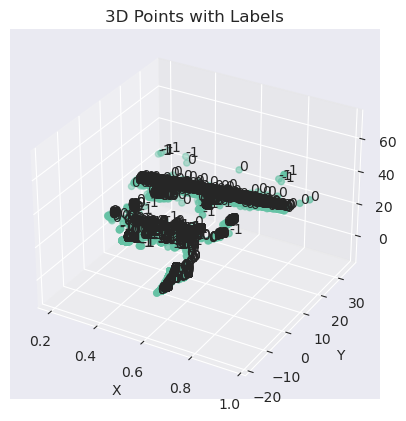

In [96]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

# Annotate each point with its label
for i, label in enumerate(labels):
    ax.text(points[i, 0], points[i, 1], points[i, 2], label)

# Adding labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Points with Labels')

# Show the plot
plt.show()

In [197]:
unique_labels = list(set(labels))
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # You can choose any colormap you like
color_dict = {label: color_map(i) for i, label in enumerate(unique_labels)}
colors = np.array([color_dict[label] for label in labels])
colors_hex = [f'rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, {c[3]})' for c in colors]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=colors_hex,  # Assign colors to each point
        opacity=0.8
    ),
    hovertext=labels,
    hoverinfo='text'
)])

# Adding labels and title
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='3D Points with Hover Labels and Unique Colors'
)

# Show the plot
fig.show()

/tmp/ipykernel_36675/1047102969.py:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7200 samples in 0.025s...
[t-SNE] Computed neighbors for 7200 samples in 0.528s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7200
[t-SNE] Computed conditional probabilities for sample 2000 / 7200
[t-SNE] Computed conditional probabilities for sample 3000 / 7200
[t-SNE] Computed conditional probabilities for sample 4000 / 7200
[t-SNE] Computed conditional probabilities for sample 5000 / 7200
[t-SNE] Computed conditional probabilities for sample 6000 / 7200
[t-SNE] Computed conditional probabilities for sample 7000 / 7200
[t-SNE] Computed conditional probabilities for sample 7200 / 7200
[t-SNE] Mean sigma: 0.003135
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.279968
[t-SNE] KL divergence after 1000 iterations: 0.979912


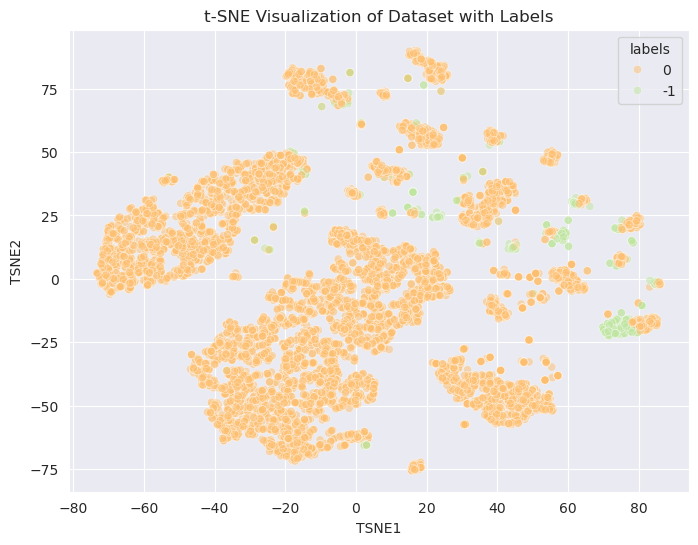

In [105]:
### 2d
utils.plot_TSNE(df, outlier_index, dist_matrix=gower.gower_matrix(df))

In [152]:
# Create a 2D scatter plot
my_2d_coord = model.encode(data_tensor).detach().numpy()

In [153]:
pd.DataFrame(outlier_index).replace({-1: 'Outlier', 0: 'Non-Outlier'}).value_counts()

Non-Outlier    6697
Outlier         503
Name: count, dtype: int64

<Axes: >

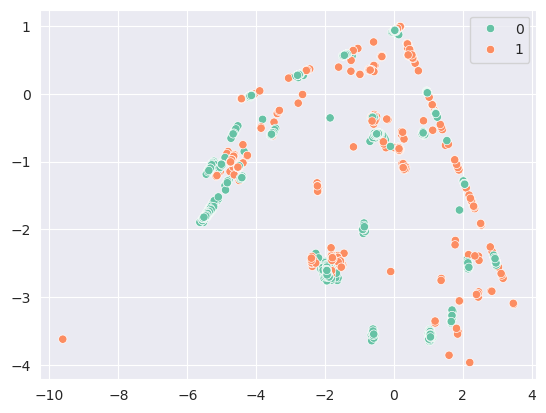

In [154]:
sns.scatterplot(x=my_2d_coord[:, 0], y=my_2d_coord[:, 1], hue= np.array(outlier_index) * -1)

In [ ]:
np.linspace(0.000001, 0.9999, 100)

In [40]:
np.argmin(df.iloc[:,14])

1077

In [37]:
df

Dim_0  Dim_1=0  Dim_2=0  Dim_3=0  Dim_4=0  Dim_5=0  Dim_6=0  Dim_7=0  \
0     0.750000        1        0        1        1        1        1        1   
1     0.239583        1        1        1        1        1        1        1   
2     0.479167        1        1        1        1        1        1        1   
3     0.656250        0        1        1        1        1        1        1   
4     0.229167        1        1        1        1        1        1        1   
...        ...      ...      ...      ...      ...      ...      ...      ...   
7195  0.604167        1        1        1        1        1        1        1   
7196  0.520833        1        1        1        1        1        1        1   
7197  0.520833        1        1        1        1        1        1        1   
7198  0.354167        0        1        1        1        1        1        1   
7199  0.750000        1        1        1        1        1        1        1   

      Dim_8=0  Dim_9=0  ...  Dim_11=0  Dim_12=0  Dim_13=0  Dim_14=0  Dim_15=0  \
0           0        1  ...         1         1         1         1         1   
1           1        1  ...         1         1         1         1         1   
2           1        1  ...         1         1         1         1         1   
3           1        1  ...         1         1         1         1         1   
4           1        1  ...         1         1         1         1         1   
...       ...      ...  ...       ...       ...       ...       ...       ...   
7195        1        1  ...         1         1         1         1         0   
7196        1        1  ...         1         1         1         1         1   
7197        1        1  ...         1         1         1         1         0   
7198        1        1  ...         1         1         1         1         1   
7199        1        1  ...         1         1         1         1         0   

        Dim_16    Dim_17    Dim_18    Dim_19    Dim_20  
0     0.001132  0.080780  0.197324  0.300926  0.225000  
1     0.000472  0.164345  0.235786  0.537037  0.165625  
2     0.003585  0.130919  0.167224  0.527778  0.118750  
3     0.001698  0.091922  0.125418  0.337963  0.129688  
4     0.000472  0.142061  0.229097  0.337963  0.235938  
...        ...       ...       ...       ...       ...  
7195  0.004717  0.113092  0.128763  0.379630  0.121875  
7196  0.200000  0.030641  0.005017  0.333333  0.005469  
7197  0.001434  0.109192  0.147157  0.231481  0.206250  
7198  0.005283  0.109192  0.147157  0.333333  0.154688  
7199  0.001057  0.109192  0.132107  0.337963  0.137500  

[7200 rows x 21 columns]

In [78]:
f = utils.sigmoid_to_prob
list(map(f(6), [0,1,2,3,4,5,6]))

[5.551115123125783e-17,
 0.4757919946628703,
 1.4683708263287862,
 3.0,
 4.531629173671214,
 5.5242080053371305,
 6.000000000000001]

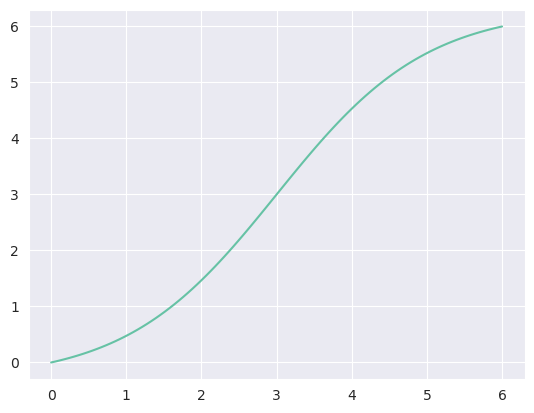

In [82]:
k = 6
x = np.linspace(0,k,100)
sigmoid_function = utils.sigmoid_to_prob(k=k)
y = list(map(sigmoid_function, x))
plt.plot(x,y)

In [75]:
print(utils.sigmoid_to_prob()(6))

None


In [6]:
labels = np.load("prob_results.npy")
df = model.encode(data_tensor).detach().numpy()
df = pd.DataFrame(df, columns=['AutoEnc1', 'AutoEnc2'])

In [7]:
df.head()

AutoEnc1  AutoEnc2
0 -1.614539 -4.775512
1  6.402705 -2.825244
2  6.713365 -3.212446
3  3.945263  3.684727
4  6.425098 -2.857882

In [44]:
df['labels'] = labels
plt.figure(figsize=(20, 12))
scatter = plt.scatter(df['AutoEnc1'], df['AutoEnc2'], c=df['labels'], cmap='viridis', alpha=0.5)

plt.colorbar(scatter, label='Probability of an observation being an outlier')
plt.title('Autoencoder Representation of Dataset with Labels')
plt.xlabel('AutoEnc1')
plt.ylabel('AutoEnc2')
plt.tight_layout()
plt.savefig('probab_result_autoencoder.png')
plt.show()


KeyError: 'AutoEnc1'

<Figure size 2000x1200 with 0 Axes>

In [128]:
import plotly.graph_objects as go
df = model.encode(data_tensor).detach().numpy()
df = pd.DataFrame(df, columns=['AutoEnc1', 'AutoEnc2', 'AutoEnc3'])
df['labels'] = labels
fig = go.Figure(data=[go.Scatter3d(
        x=df['AutoEnc1'],
        y=df['AutoEnc2'],
        z=df['AutoEnc3'],
        mode='markers',
        marker=dict(
            size=6,
            color=df['labels'], # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        )
    )])
fig.show()

In [13]:
data = preprocessing.load_dataset()

In [19]:
data['Dim_14=0'].value_counts()

Dim_14=0
1    7199
0       1
Name: count, dtype: int64

In [21]:
i = np.argmin(data['Dim_14=0'])
i

1077

In [23]:
labels[i]

1.0000000000000002